In [3]:
import os

# Must be set BEFORE importing everybeam or hamaker
os.environ['EVERYBEAM_DATA'] = '/home/sleepypanda/everybeam'
os.environ['CASAPATH'] = '/path/to/casa'

import everybeam as eb
import casatasks, casatools

/home/sleepypanda/miniconda3/envs/Beam/lib/python3.10/site-packages/casaconfig/private/measures_update.py:133: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
import everybeam as eb
import numpy as np
import os
from pathlib import Path
from numpy import pi
import matplotlib.pyplot as plt

from everybeam import load_telescope, LOFAR, Options, thetaphi2cart
import logging, sys

from astropy.coordinates import AltAz, EarthLocation, ITRS, SkyCoord
from astropy.time import Time
import astropy.units as u

import casacore.tables as ct

import matplotlib.patches as mp

from parallelize import parmap
import time

import hamaker

# %cd /media/plato/asad/losito/losito/data/ms_templates

d = '/home/sleepypanda/Desktop/CASSA IUB Chronos/Codes/Everybeam/'


In [4]:
from numpy import pi 

startime = 4.92183348e09
intime = 12.
tres = 60. * 10.
ra = 2. * pi/180. # change this
dec_deg = 60 # change this
dec = dec_deg * pi/180.
name = d+f'synthms_hba_dec{dec_deg}'
station = 'HBA'
fmin = 110e6
fmax = 170e6
nchan = 4

In [ ]:
cmd = f"python /home/sleepypanda/losito/bin/synthms --name {name} --start {startime} --tobs {intime} --ra {ra} --dec {dec} --station {station} --tres {tres} --minfreq {fmin} --maxfreq {fmax} --chanpersb {nchan}"

print(cmd)
os.system(cmd)

In [27]:
import subprocess
import sys

python_bin = sys.executable  # Python used by this kernel
cmd = [
    python_bin,
    "/home/sleepypanda/losito/bin/synthms",
    "--name", name,
    "--start", str(startime),
    "--tobs", str(intime),
    "--ra", str(ra),
    "--dec", str(dec),
    "--station", station,
    "--tres", str(tres),
    "--minfreq", str(fmin),
    "--maxfreq", str(fmax),
    "--chanpersb", str(nchan)
]

# Run the command in the current kernel's environment
subprocess.run(cmd)

/home/sleepypanda/losito/bin/synthms:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


[=======================================-] 98.6% ...Make first SB

CompletedProcess(args=['/home/sleepypanda/miniconda3/envs/Beam/bin/python', '/home/sleepypanda/losito/bin/synthms', '--name', '/home/sleepypanda/Desktop/CASSA IUB Chronos/Codes/Everybeam/synthms_hba_dec60', '--start', '4921833480.0', '--tobs', '12.0', '--ra', '0.03490658503988659', '--dec', '1.0471975511965976', '--station', 'HBA', '--tres', '600.0', '--minfreq', '110000000.0', '--maxfreq', '170000000.0', '--chanpersb', '4'], returncode=0)

In [12]:
# SOLUTION 1: Create a symbolic link to avoid spaces
# This creates a symlink without spaces that points to your actual directory
symlink_path = Path('/tmp/everybeam_data')
actual_path = Path('/media/sleepypanda/New Volume1/Personal/Research Works/CASSA IUB Chronos/Codes/Everybeam')

# Create symlink if it doesn't exist
if not symlink_path.exists():
    try:
        symlink_path.symlink_to(actual_path)
        print(f"Created symlink: {symlink_path} -> {actual_path}")
    except Exception as e:
        print(f"Failed to create symlink: {e}")

Created symlink: /tmp/everybeam_data -> /media/sleepypanda/New Volume1/Personal/Research Works/CASSA IUB Chronos/Codes/Everybeam


In [13]:
# Your MS file parameters
symlink_path = Path('/tmp/everybeam_data')

base_path = symlink_path
base_name = 'synthms_hba_dec60_t201411041558_SBH'
ms_file = str(base_path / f"{base_name}51.MS")

def get_central_frequency(ms_file):
    """Get the central frequency of an MS file"""
    tb = casatools.table()
    try:
        tb.open(ms_file + '/SPECTRAL_WINDOW')
        
        # Get frequency array for first (and likely only) SPW
        chan_freq = tb.getcell('CHAN_FREQ', 0)  # Hz
        tb.close()
        
        # Central frequency
        central_freq_hz = chan_freq[len(chan_freq)//2]
        central_freq_mhz = central_freq_hz / 1e6
        
        return central_freq_mhz, len(chan_freq)
        
    except Exception as e:
        if tb.isopened():
            tb.close()
        return None, None                    

In [14]:
central_freq, nchan = get_central_frequency(ms_file)

print(central_freq, nchan)

110.0341796875 4


In [2]:
# #single core 
# ms_path = 'synthms_hba_dec90_t201411041558_SBH51.MS'

# npix = 2049
# freqs = np.arange(110, 171)*1e6
# time = 4.92183348e09
# station = 0

# for i, f in enumerate(freqs):
#     J = hamaker.allsky_beam(ms_path, time, f, station_id=station, npix=npix)
#     np.save('beam_%i.npy'%(f/1e6), J)
    

In [2]:
# Function to calculate beam for a single frequency
def calculate_single_freq_beam(freq):
    ms_path = d+'synthms_hba_dec60_t201411041558_SBH51.MS'
    npix = 2049
    timestamp = 4.92183348e09
    station = 0
    
    freq_mhz = int(freq/1e6)
    print(f"Processing frequency {freq_mhz} MHz")
    
    # Calculate the beam
    J = hamaker.allsky_beam(ms_path, timestamp, freq, station_id=station, npix=npix)
    
    # Save the result
    np.save(f'beam_{freq_mhz}.npy', J)
    
    return freq_mhz

In [3]:
# Run the parallel calculation
freqs = np.arange(130, 131) * 1e6
start_time = time.time()

# Use 80% of available cores
results = parmap(calculate_single_freq_beam, freqs, proc_power=0.8)

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Processed frequencies: {sorted(results)}")

Processing frequency 130 MHz
Total execution time: 58.18 seconds
Processed frequencies: [130]


In [21]:
freqs = np.arange(130, 131) * 1e6
results = []
for f in freqs:
    results.append(calculate_single_freq_beam(f))

Processing frequency 130 MHz


TypeError: allsky_beam() got an unexpected keyword argument 'coeff_file'

In [4]:
# import numpy as np
# # !ls '/media/plato/lofar/beam/'
# d = np.load('/home/sleepypanda/Desktop/CASSA IUB Chronos/Codes/Cassa Workshop 1 EveryBeam/Important/beam_130.npy')

/tmp/ipykernel_10247/4209113936.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)


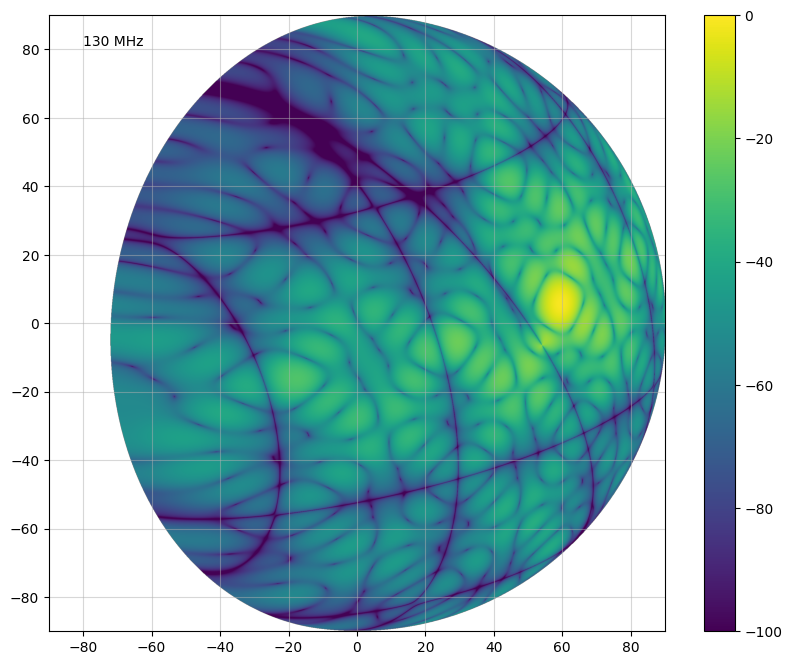

In [23]:
dout = "/home/sleepypanda/Desktop/CASSA IUB Chronos/Codes/Cassa Workshop 1 EveryBeam/Important/output/"
plt.figure(figsize=(10,8))

freq = 130

J = np.load('beam_%i.npy'%freq)
plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)
plt.colorbar()
plt.grid(alpha=0.5)
plt.text(-80, 81, "130 MHz")
plt.savefig(dout + "%i.png"%freq)

/tmp/ipykernel_1844809/2858927337.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)


Text(-80, 81, '138 MHz')

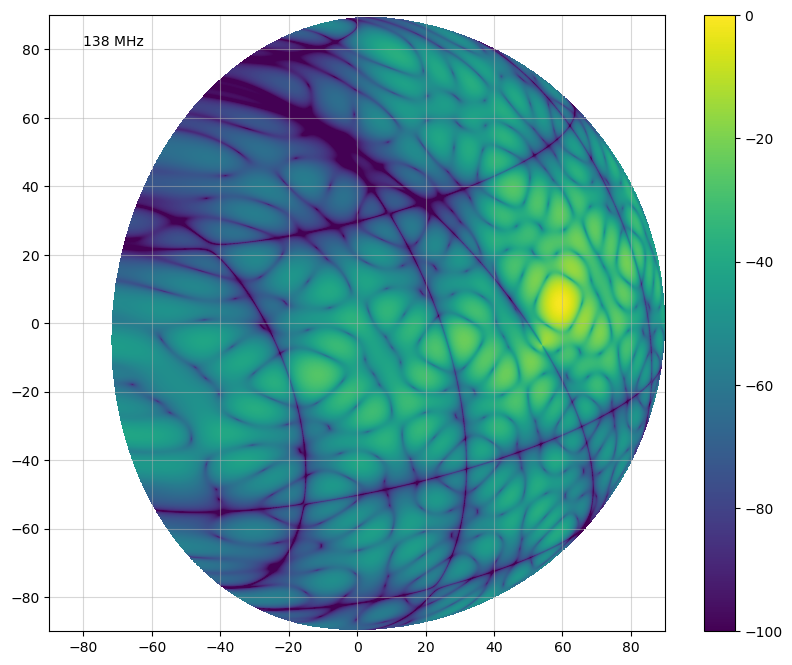

In [10]:
dout = '/media/plato/lofar/beam/'
plt.figure(figsize=(10,8))

freq = 138

J = np.load(dout+'beam_%i.npy'%freq)
plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)
plt.colorbar()
plt.grid(alpha=0.5)
plt.text(-80, 81, "%i MHz"%freq)

/tmp/ipykernel_1844809/1141489131.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)


Text(-80, 81, '133 MHz')

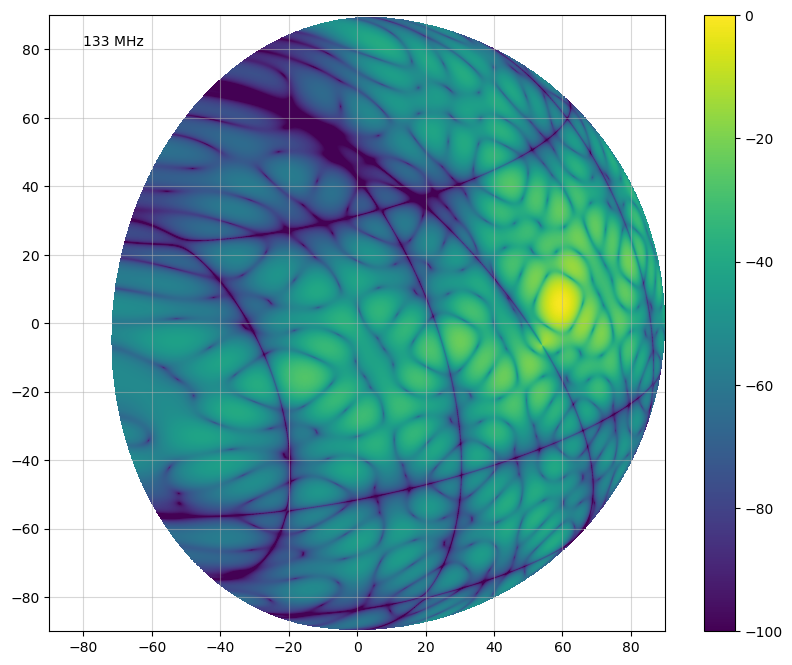

In [11]:
dout = '/media/plato/lofar/beam/'
plt.figure(figsize=(10,8))

freq = 133

J = np.load(dout+'beam_%i.npy'%freq)
plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)
plt.colorbar()
plt.grid(alpha=0.5)
plt.text(-80, 81, "%i MHz"%freq)